In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [1]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo



In [127]:
from goatools.associations import read_ncbi_gene2go
from goatools.go_search import GoSearch

go2geneids_human = read_ncbi_gene2go("gene2go", taxids=[9606], namespace='BP', go2geneids=True)
# go2geneids_human.update(read_ncbi_gene2go("gene2go", taxids=[9606], namespace='MF', go2geneids=True))
# go2geneids_human.update(read_ncbi_gene2go("gene2go", taxids=[9606], namespace='CC', go2geneids=True))
print("{N} GO terms associated with human NCBI Entrez GeneIDs".format(N=len(go2geneids_human)))

srchhelp = GoSearch("go-basic.obo", go2items=go2geneids_human)

from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT

DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: <ipython-input-127-3038c6e81672> BY <module>
HMS:0:00:03.057617 323,107 annotations READ: gene2go 
1 taxids stored: 9606
12285 IDs in loaded association branch, BP
DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: <ipython-input-127-3038c6e81672> BY <module>
HMS:0:00:03.261971 323,107 annotations READ: gene2go 
1 taxids stored: 9606
4170 IDs in loaded association branch, MF
DEPRECATED read_ncbi_gene2go: USE Gene2GoReader FROM goatools.anno.genetogo_reader
DEPRECATED read_ncbi_gene2go CALLED FROM: <ipython-input-127-3038c6e81672> BY <module>
HMS:0:00:02.654075 323,107 annotations READ: gene2go 
1 taxids stored: 9606
1737 IDs in loaded association branch, CC
18192 GO terms associated with human NCBI Entrez GeneIDs
go-basic.obo: fmt(1.2) rel(2020-01-01) 47,337 GO Terms; optional_attrs(comment

In [241]:
from statsmodels.stats import multitest
from matplotlib_venn import venn3, venn2

def load_results(pattern, fdr_method = "fdr_bh", cols=None):
    df = pd.concat((pd.read_csv(path) 
                for path in glob.glob(pattern)), sort=False).set_index(["feature","gene"])
    cols = cols or df.columns
    df = df.dropna(subset=cols)
    df[cols] = (df.groupby(level="feature")[cols]
            .transform(lambda col: multitest.multipletests(col, method=fdr_method)[1])
          )
    return df


def sort_genes(df, pval, thresh):
    genes_all = df[pval].loc[lambda df: df < thresh].index.get_level_values('gene').unique()
    counts = df[pval].apply(lambda df: df < thresh).groupby(level="feature").sum().sort_values(ascending=False)
    return counts, genes_all

def genes_by_feature(df, features, pval, thresh):
    top = (
        df.loc[features]
        .loc[lambda df: df[pval] < thresh]
        .groupby(level="feature")
    #     .apply(lambda df: df.reset_index().sort_values(col, ascending=True)["gene"])
        .apply(lambda df: df.sort_values(pval).index.get_level_values("gene"))
    )
    return top

def go_dict(go_id):
    gos = srchhelp.add_children_gos([go_id])
    ids = srchhelp.get_items(gos)
    return {GENEID2NT[geneid].Symbol: GENEID2NT[geneid] for geneid in ids if geneid in GENEID2NT}

def go_intersection(symbols, go_id):
    lookup = go_dict(go_id)
    return [lookup.get(symbol) for symbol in symbols if symbol in lookup]

Text(0.5, 1.0, 'Number of sig. genes for correlation model (FDR<0.05)')

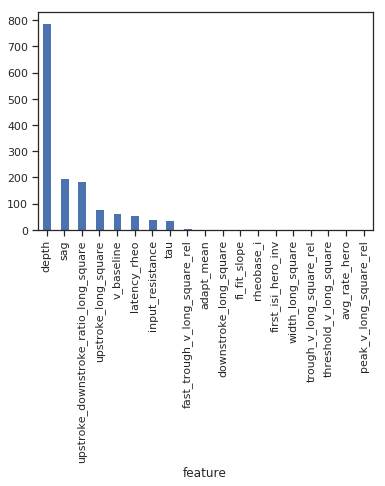

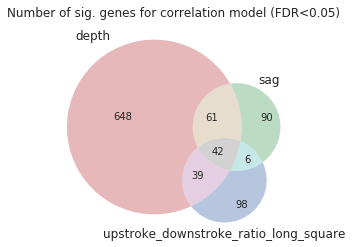

In [270]:
df = load_results('../data/frem_gene_depth/frem_gene_depth*.csv', cols=['p_corr'])
pval = "p_corr"
thresh=0.05
counts, genes_sorted = sort_genes(df, pval=pval, thresh=thresh)
counts.plot.bar()
top = genes_by_feature(df, counts.index[:3], pval=pval, thresh=thresh)
plt.figure()
venn3(top.apply(set), top.index)
plt.title(f"Number of sig. genes for correlation model (FDR<{thresh})")

In [284]:
cols = [
    'term_ID',
    'description',
    'log10 p-value'
]
names = [
    'GO term ID',
    'GO term description',
    'GO term log10 p-value'
]
revigo = pd.read_csv(Path('../data/REVIGO_results.csv'))
df_go = revigo.head(5)[cols].rename(columns=dict(zip(cols, names))).set_index('GO term ID')

In [302]:
cols = [
#     'gene',
    'p_corr',
    'rsquared_corr',
    'r_corr'
]
names = [
#     'gene',
    'q-value (FDR-BH)',
    'Rsquared',
    'r (pearson)'
]

results = []
for go_id in df_go.index:
    genes = [gene.Symbol for gene in go_intersection(top['depth'], go_id)]
    go_genes_df = df.loc[pd.IndexSlice['depth', genes],:].sort_values("p_corr").head(10).reset_index(level='feature')
    results.append(go_genes_df)
genes_df = pd.concat(results, keys=df_go.index)[cols].rename(columns=dict(zip(cols, names)))
combined = genes_df.join(df_go)
# combined.to_csv('/home/tom.chartrand/figs/supp_depth_genes_go.csv')
combined.head(20)

q-value (FDR-BH)  Rsquared  r (pearson)  \
GO term ID gene                                               
GO:0007268 RIT2         1.333551e-13  0.369687     0.608019   
           KCNIP2       3.960494e-10  0.294559    -0.542733   
           SNCG         5.847890e-09  0.267811     0.517504   
           GRM3         2.026451e-06  0.202726     0.450251   
           HTR1F        2.027741e-05  0.175566     0.419006   
           KCNQ3        2.953425e-05  0.170981     0.413498   
           NPTX2        3.917377e-05  0.167573    -0.409357   
           GRID2        2.386679e-04  0.143347    -0.378612   
           CACNA1E      5.127567e-04  0.132721    -0.364309   
           EXOC4        1.358855e-03  0.120197    -0.346695   
GO:0048812 NTNG1        5.753576e-08  0.242395     0.492336   
           NEFL         1.024846e-03  0.123812     0.351869   
           EPB41L3      2.740114e-03  0.110458    -0.332352   
           TNIK         3.636135e-03  0.106313     0.326056   
           BCL2         4.298613e-03  0.104342    -0.323020   
           PHACTR1      5.445213e-03  0.100485    -0.316993   
           PARD3        1.121512e-02  0.089809    -0.299682   
           PAX2         1.121512e-02  0.089819    -0.299699   
           CCK          1.474683e-02  0.085679     0.292709   
           DCC          1.809047e-02  0.082197     0.286701   

                                GO term description  GO term log10 p-value  
GO term ID gene                                                             
GO:0007268 RIT2      chemical synaptic transmission               -12.5035  
           KCNIP2    chemical synaptic transmission               -12.5035  
           SNCG      chemical synaptic transmission               -12.5035  
           GRM3      chemical synaptic transmission               -12.5035  
           HTR1F     chemical synaptic transmission               -12.5035  
           KCNQ3     chemical synaptic transmission               -12.5035  
           NPTX2     chemical synaptic transmission               -12.5035  
           GRID2     chemical synaptic transmission               -12.5035  
           CACNA1E   chemical synaptic transmission               -12.5035  
           EXOC4     chemical synaptic transmission               -12.5035  
GO:0048812 NTNG1    neuron projection morphogenesis               -11.1229  
           NEFL     neuron projection morphogenesis               -11.1229  
           EPB41L3  neuron projection morphogenesis               -11.1229  
           TNIK     neuron projection morphogenesis               -11.1229  
           BCL2     neuron projection morphogenesis               -11.1229  
           PHACTR1  neuron projection morphogenesis               -11.1229  
           PARD3    neuron projection morphogenesis               -11.1229  
           PAX2     neuron projection morphogenesis               -11.1229  
           CCK      neuron projection morphogenesis               -11.1229  
           DCC      neuron projection morphogenesis               -11.1229